# Exercice Machine Learning Selectra

Arnaud Fabre 2018

In [1]:
# DataScience libs
import pandas as pd
import numpy as np

In [2]:
# DataViz libs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Reading data
data_read = pd.read_csv("data_music_replay_train")
data = data_read.copy()

## Showing correlations

The very first step of a machine learning process is to understand the data.

In [4]:
# Show a sample of the data
data.sample(4)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,language,remaining_days
101779,4162,44993,listen with,Others profile more,listen-with,1,1,0,NaN,7,2011-11-25,2017-09-14,213551,465,52.0,2120
340507,15040,7232,search,Online playlist more,online-playlist,1,1,0,NaN,7,2013-11-28,2017-09-23,253492,465,3.0,1395
19742,25140,15634,my library,Local playlist more,local-library,1,5,24,female,9,2011-12-08,2017-11-26,238654,465,3.0,2180
645568,11088,19718,discover,Discover Feature,online-playlist,0,1,0,NaN,7,2014-10-07,2017-10-06,305293,2122,3.0,1095


In [5]:
# Show feature properties
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
msno,663957.0,13659.028247,7873.546059,0.0,6854.0,13723.0,20526.0,27218.0
song_id,663957.0,56475.518228,32723.693649,0.0,28015.0,56246.0,84349.0,113332.0
target,663957.0,0.502484,0.499994,0.0,0.0,1.0,1.0,1.0
city,663957.0,7.512226,6.643304,1.0,1.0,5.0,13.0,22.0
bd,663957.0,17.535374,21.499614,-43.0,0.0,21.0,29.0,1030.0
registered_via,663957.0,6.793684,2.275819,3.0,4.0,7.0,9.0,13.0
song_length,663957.0,245059.429103,67391.013986,1950.0,214622.0,241684.0,272195.0,7575835.0
language,663953.0,18.598420,21.186004,-1.0,3.0,3.0,52.0,59.0
remaining_days,663957.0,1627.231030,1127.995910,-16191.0,701.0,1434.0,2286.0,5149.0


We have to transform categorical feature into numerical feature as ML algorithms use numerical feature

In [87]:
# Identify possible issues with some columns
data.dtypes

msno                    int64
song_id                 int64
source_system_tab        int8
source_screen_name       int8
source_type              int8
target                  int64
city                    int64
bd                    float64
gender                  int64
registered_via          int64
song_length             int64
language              float64
remaining_days          int64
genre_id               object
snd_genre_id           object
trd_genre_id           object
dtype: object

In [88]:
# genre_ids is a combination of differents types
# We are going to get value that are not numbers
not_numbers = data_read.genre_ids.astype(str).apply(lambda x: x.isnumeric()) == False
data_read["genre_ids"][not_numbers.values].sample(10)

627500      465|430
255453      921|465
155361      786|947
656623     465|2022
643458          NaN
151719          NaN
285805          NaN
280518     444|1259
566341     465|2022
45659     1616|1609
Name: genre_ids, dtype: object

We see that some element have multiple genre or not, for our first algorith we will only select the first genre

In [89]:
data["bd"].describe()

count    663957.000000
mean         28.303090
std          16.103284
min           2.000000
25%          26.000000
50%          27.000000
75%          29.000000
max        1030.000000
Name: bd, dtype: float64

bd is the age so it should not be negative or 0 we will replace outliers with the median value

In [90]:
data.isnull().any()

msno                  False
song_id               False
source_system_tab     False
source_screen_name    False
source_type           False
target                False
city                  False
bd                    False
gender                False
registered_via        False
song_length           False
language              False
remaining_days        False
genre_id              False
snd_genre_id          False
trd_genre_id          False
dtype: bool

We see that some language are NaN, let see more in depth

In [91]:
data[data.language.isnull()]

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,song_length,language,remaining_days,genre_id,snd_genre_id,trd_genre_id


We only have a few NaN we will set a default value for these

In [101]:
def bd_outlier(age):
    if age <= 0:
        return None
    return age

def cat_gender(g):
    if g == "male":
        return 1
    elif g == "female":
        return -1
    else:
        return 0
    
def cat_genre(g):
    # Select first genre
    try:
        return(int(g))
    except:
        if isinstance(g, str):
            return g.split("|")[0]
        else:
            return 0

def snd_genre(g):
    # Select first genre
    try:
        return g.split("|")[1]
    except:
        return 0
        
def correct_language(l):
    if l is None or l < 0:
        return 0
    return l

data = data_read.copy()
bd_median = data_read["bd"].apply(bd_outlier).median()
data["bd"] = data_read["bd"].apply(bd_outlier).fillna(bd_median)
data["gender"] = data["gender"].apply(cat_gender)
data["source_type"] = data["source_type"].astype("category").cat.codes
data["source_screen_name"] = data["source_screen_name"].astype("category").cat.codes
data["source_system_tab"] = data["source_system_tab"].astype("category").cat.codes
data["genre_id"] = data["genre_ids"].apply(cat_genre)
data["snd_genre_id"] = data["genre_ids"].apply(snd_genre)
data["language"] = data["language"].apply(correct_language).fillna(0)
data.drop(["registration_init_time", "expiration_date", "genre_ids"], axis=1, inplace=True)

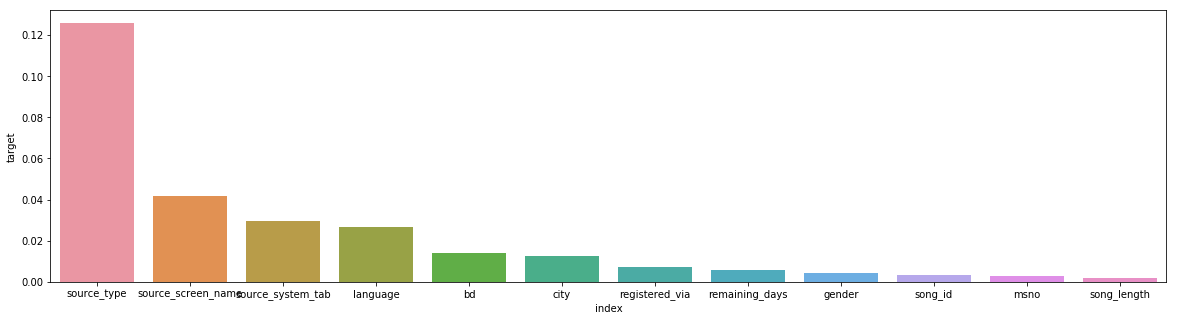

In [102]:
# Correlation value with column "target"
corr = data.corr()[["target"]].abs().sort_values(by="target", ascending=False).reset_index()
# drop target/target correlation
corr.drop(0, inplace=True)
fig = plt.figure(figsize=(20,5));
sns.barplot(x="index", y="target", data=corr, ax=plt.subplot(111))

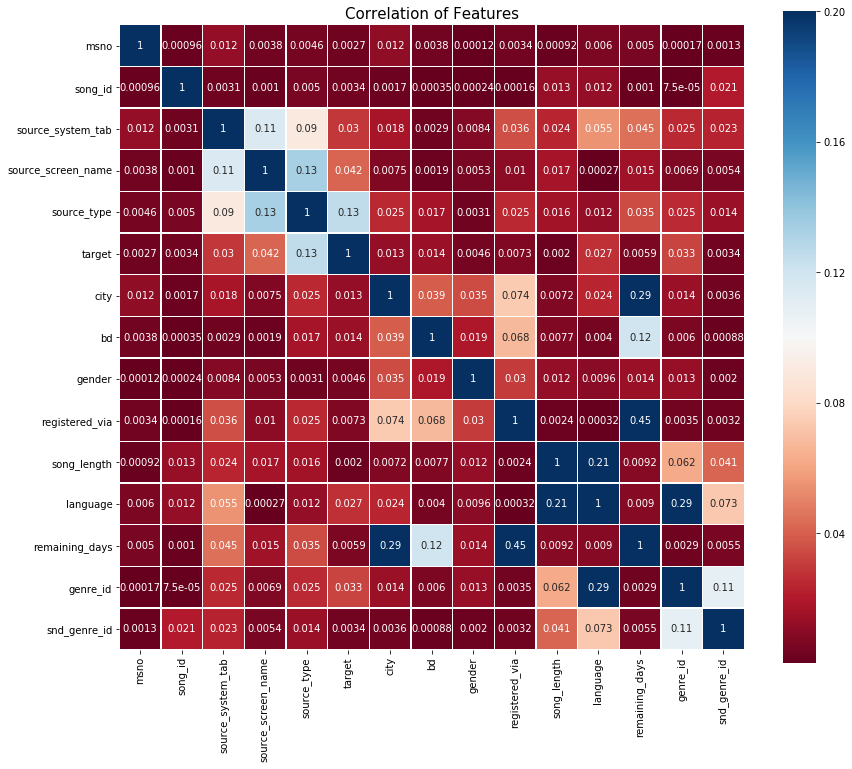

In [103]:
plt.figure(figsize=(14,12))
plt.title("Correlation of Features", y=1, size=15)
sns.heatmap(data.astype(float).corr().abs(), linewidths=0.1,vmax=0.2, square=True, cmap=plt.cm.RdBu, linecolor="white", annot=True)

In [104]:
corr

,index,target
1,source_type,0.125735
2,source_screen_name,0.041738
3,source_system_tab,0.029667
4,language,0.026711
5,bd,0.013852
6,city,0.012527
7,registered_via,0.007254
8,remaining_days,0.005940
9,gender,0.004554
10,song_id,0.003441


We can see that the dataset exhibit some correlation

# ML - Training

In [105]:
# Utilities
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import preprocessing

First we split the dataset into 3 part : training / testing

This step is really important to not overfitting our model by training it on the test set.

- Training set is used to train our model
- Testing set is used to calculate our model accuracy

The learning algorithm must not see at all any data of the test set!

In [106]:
from sklearn.model_selection import train_test_split
seed = 444
data_fit = data.copy()
X_all_full = data_fit.drop("target", axis=1)
y_all_full = data_fit["target"]

# Many classifier excepts data to be normalized
scaler = preprocessing.StandardScaler()
columns = X_all_full.columns
X_all_full = pd.DataFrame(scaler.fit_transform(X_all),columns=X_all.columns, index=X_all.index)

# For the sake of simplicity we will demonstrate algorithms on a really small subset of the data, to keep calculation short
X_train, X_test, y_train, y_test = train_test_split(X_all_full, y_all_full, test_size=0.99, random_state=seed)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_all_full, y_all_full, test_size=0.6, random_state=seed)

## Fitting

In [107]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#### First classifiers

In [108]:
classifiers = {}
for clf_class in [LogisticRegression, RandomForestClassifier, GaussianNB, DecisionTreeClassifier, GradientBoostingClassifier]:
    clf = clf_class()
    clf.fit(X_train, y_train)
    classifiers[clf.__class__.__name__] = clf
    print(clf.__class__.__name__)
    print(accuracy_score(y_test, clf.predict(X_test)))

LogisticRegression
0.580930386814
RandomForestClassifier
0.57680757259
GaussianNB
0.583718991417
DecisionTreeClassifier
0.54377941879
GradientBoostingClassifier
0.620734560745


#### Fine tunning classifier parameters

We will use [grid search](http://scikit-learn.org/stable/modules/grid_search.html) to fine tune classifiers' parameters.

Since sklearn claissifiers api are all similar we can use a helper class to do the grid search.

In [109]:
class SkLeanrnClassifier:
    def __init__(self, clf, parameters, X_train, y_train):
        self.clf = clf
        self.parameters = parameters
        self.X_train = X_train
        self.y_train = y_train
        
    def grid_search(self):
        acc_scorer = make_scorer(accuracy_score)

        # Run the grid search
        grid_obj = GridSearchCV(self.clf, self.parameters, scoring=acc_scorer, n_jobs=-1, cv=5)
        grid_obj = grid_obj.fit(X_train, y_train)

        # Set the clf to the best combination of parameters
        return grid_obj

In [110]:
parameters = {
    "n_estimators": [4, 6, 9], 
    "max_features": ["log2", "sqrt", "auto"], 
    "criterion": ["gini"],
    "max_depth": [2, 3, 5, 10], 
    "min_samples_split": [2, 3, 5, 10],
    "min_samples_leaf": [1, 5, 8]
}

grid_search = SkLeanrnClassifier(RandomForestClassifier(), parameters, X_train, y_train).grid_search()

In [111]:
# We can see which parameters gave the best results
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'n_estimators': 9}

In [112]:
rf_clf = grid_search.best_estimator_
predictions = rf_clf.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
classifiers["RandomForestClassifier"] = rf_clf

             precision    recall  f1-score   support

          0       0.61      0.67      0.64    327006
          1       0.64      0.58      0.61    330312

avg / total       0.62      0.62      0.62    657318

0.622237638403


We have a slighly better accuracy (60% vs 56%)

In [113]:
parameters = [
  {"C": [1, 10, 100, 1000], "kernel": ["linear"]},
  {"C": [1, 10, 100, 1000], "gamma": [0.01, 0.001, 0.0001], "kernel": ["rbf"]},
]
# SVM fine tuning is cpu-intensive let's take it aside for the moment
# grid_search = SkLeanrnClassifier(SVC(), parameters, X_train, y_train).grid_search()

In [114]:
# grid_search.best_params_

In [115]:
"""
svc_clf = grid_search.best_estimator_
predictions = svc_clf.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
classifiers["SVC"] = svc_clf
"""
pass

Here we did not have a great improovment, because the default parameters were already the best guessed parameters

## Analysis

##### Feature importance

In [116]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
algorithm="SAMME",
n_estimators=200)
bdt.fit(X_train, y_train)
predictions = bdt.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
classifiers["AdaBoostClassifier"] = bdt

             precision    recall  f1-score   support

          0       0.61      0.67      0.64    327006
          1       0.64      0.58      0.61    330312

avg / total       0.63      0.62      0.62    657318

0.624355334861


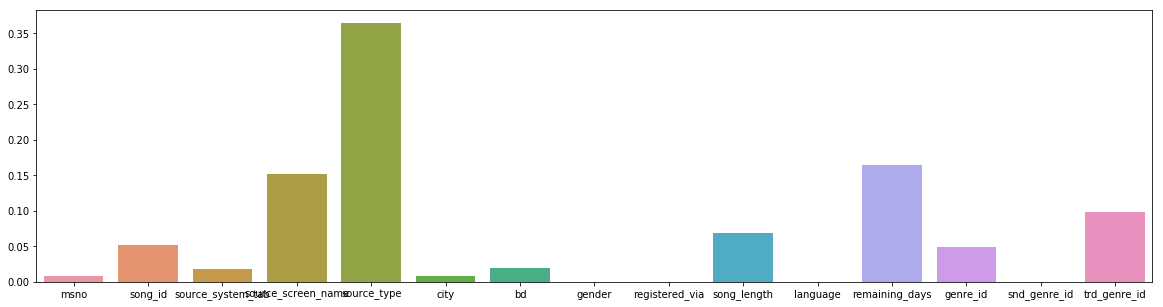

In [117]:
# AdaBoost
fig = plt.figure(figsize=(20,5));
sns.barplot(
    y=classifiers["AdaBoostClassifier"].feature_importances_,
    x=X_train.columns, ax=plt.subplot(111))

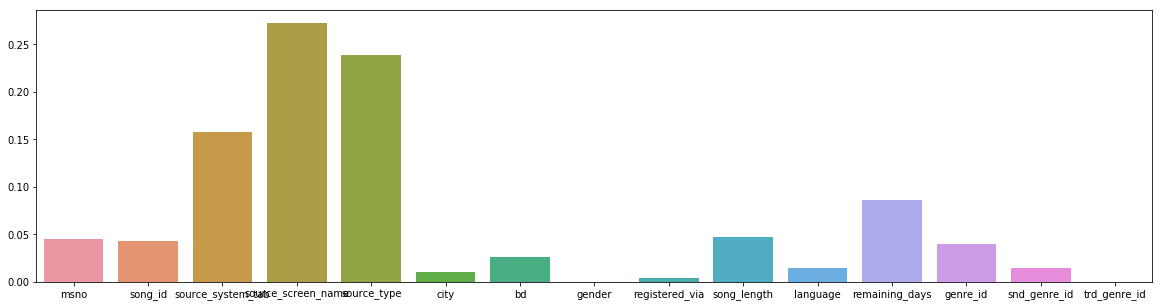

In [118]:
# Random Forest
fig = plt.figure(figsize=(20,5));
sns.barplot(
    y=classifiers["RandomForestClassifier"].feature_importances_,
    x=X_train.columns, ax=plt.subplot(111))

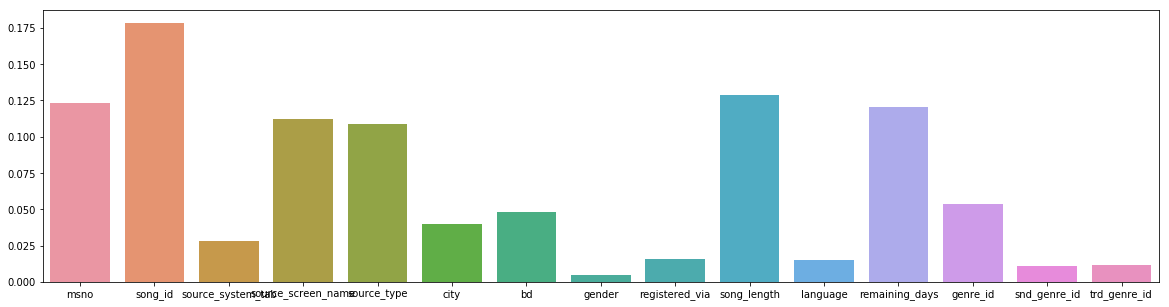

In [119]:
# Gradiant boosting
fig = plt.figure(figsize=(20,5));
sns.barplot(
    y=classifiers["GradientBoostingClassifier"].feature_importances_,
    x=X_train.columns, ax=plt.subplot(111))

We see that these classifiers don't use the same feature with the same importance, that means that we can hope to get better results with combining theses classifiers.

In [120]:
eclf1 = VotingClassifier(estimators=[
        ("ada", classifiers["AdaBoostClassifier"]), 
        ("rf", classifiers["RandomForestClassifier"]), 
        ("gb", classifiers["GradientBoostingClassifier"])
    ], 
    voting="hard")
eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

             precision    recall  f1-score   support

          0       0.61      0.66      0.64    327006
          1       0.64      0.59      0.61    330312

avg / total       0.63      0.62      0.62    657318

0.624210808163
